## Hands-on
go to https://notebooks.csc.fi
Launch a notebook Jupyter Machine Learning
Install MXNet v1.5 and its dependencies:
!pip install mxnet==1.5.1
!pip install requests matplotlib opencv-python-headless
go to https://mxnet.apache.org/versions/1.0.0/tutorials/python/predict_image.html and download the predict_image.ipynb notebook.
Perform different prediction for images on different urls.

## Prerequisites

In [1]:
!pip install mxnet==1.5.1

     |████████████████████████████████| 23.1 MB 4.4 MB/s eta 0:00:01                        | 2.6 MB 4.4 MB/s eta 0:00:05                 | 7.7 MB 4.4 MB/s eta 0:00:04��█████████████▌              | 12.7 MB 4.4 MB/s eta 0:00:03�███████████▍       | 17.6 MB 4.4 MB/s eta 0:00:02 eta 0:00:01
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.13.2
    Uninstalling graphviz-0.13.2:
      Successfully uninstalled graphviz-0.13.2


In [2]:
!pip install requests matplotlib opencv-python-headless

     |████████████████████████████████| 47.6 MB 2.5 MB/s eta 0:00:0100:16 MB 2.5 MB/s eta 0:00:1319.6 MB 2.5 MB/s eta 0:00:12/s eta 0:00:09��        | 35.0 MB 2.5 MB/s eta 0:00:05MB/s eta 0:00:03ta 0:00:01


## Loading

In [3]:
import mxnet as mx
path='http://data.mxnet.io/models/imagenet-11k/'
[mx.test_utils.download(path+'resnet-152/resnet-152-symbol.json'),
 mx.test_utils.download(path+'resnet-152/resnet-152-0000.params'),
 mx.test_utils.download(path+'synset.txt')]

['resnet-152-symbol.json', 'resnet-152-0000.params', 'synset.txt']

In [4]:
sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-152', 0)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)
with open('synset.txt', 'r') as f:
    labels = [l.rstrip() for l in f]

## Predicting

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(url, show=False):
    # download and show the image
    fname = mx.test_utils.download(url)
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    return img

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], labels[i]))

probability=0.214994, class=n02122948 kitten, kitty
probability=0.108970, class=n02124313 Abyssinian, Abyssinian cat
probability=0.077683, class=n02122878 tabby, queen
probability=0.044941, class=n02808304 bath towel
probability=0.040327, class=n02849154 blanket, cover


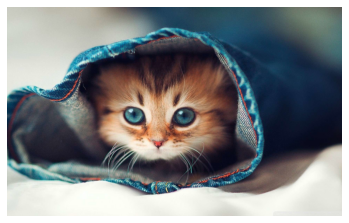

In [20]:
predict('https://wallpaperaccess.com/full/1751257.jpg')

probability=0.397136, class=n02110958 pug, pug-dog
probability=0.111041, class=n13905792 wrinkle, furrow, crease, crinkle, seam, line
probability=0.030306, class=n02084732 pooch, doggie, doggy, barker, bow-wow
probability=0.028255, class=n02085374 toy dog, toy
probability=0.026419, class=n02083346 canine, canid


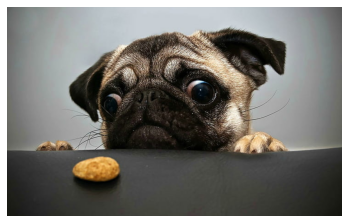

In [21]:
predict('https://c4.wallpaperflare.com/wallpaper/408/902/422/pug-cookie-wallpaper-preview.jpg')

probability=0.357279, class=n02122878 tabby, queen
probability=0.127210, class=n02122948 kitten, kitty
probability=0.111669, class=n02120997 feline, felid
probability=0.078415, class=n02122298 kitty, kitty-cat, puss, pussy, pussycat
probability=0.059010, class=n01318894 pet


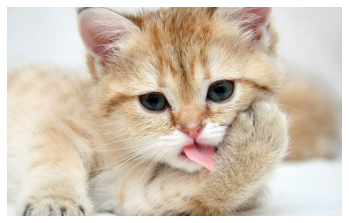

In [22]:
predict('https://i.pinimg.com/originals/69/2e/64/692e6421912e29184674dd58ef9f5e18.jpg')

## Feature extraction

In [23]:
# list the last 10 layers
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['bn1_moving_var',
 'bn1_output',
 'relu1_output',
 'pool1_output',
 'flatten0_output',
 'fc1_weight',
 'fc1_bias',
 'fc1_output',
 'softmax_label',
 'softmax_output']

In [24]:
fe_sym = all_layers['flatten0_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.cpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

In [25]:
img = get_image('https://wallpaperaccess.com/full/1751257.jpg')
fe_mod.forward(Batch([mx.nd.array(img)]))
features = fe_mod.get_outputs()[0].asnumpy()
print(features)
assert features.shape == (1, 2048)

[[2.2126453  1.7628496  0.1432572  ... 0.9064198  0.07153737 2.2839427 ]]


In [18]:
img = get_image('https://c4.wallpaperflare.com/wallpaper/408/902/422/pug-cookie-wallpaper-preview.jpg')
fe_mod.forward(Batch([mx.nd.array(img)]))
features = fe_mod.get_outputs()[0].asnumpy()
print(features)
assert features.shape == (1, 2048)

[[0.20959423 1.7961795  0.49700075 ... 0.7349409  0.2095553  1.9137183 ]]


In [17]:
img = get_image('https://i.pinimg.com/originals/69/2e/64/692e6421912e29184674dd58ef9f5e18.jpg')
fe_mod.forward(Batch([mx.nd.array(img)]))
features = fe_mod.get_outputs()[0].asnumpy()
print(features)
assert features.shape == (1, 2048)

[[0.38227063 0.48154607 0.01187714 ... 0.52235734 0.02767349 0.16319819]]
